## AIMI High School Internship 2024
### Notebook 2: Training a Computer Vision Model to Classify Pneumonia

**The Problem**: Given a chest X-ray, our goal in this project is to classify the image into one of four classes: **pneumonia, pneumothorax, pleural effusion**, and **normal**.  

**Your Second Task**: You should now have a training dataset consisting of (a) chest X-rays and (b) labels extracted from radiologist reports processed using NLP or a similar technique. Now, your goal is to train a computer vision model to classify the images. You have **two options** for this task, and you may attempt one or both of these:
- *Standard Classification* : Train a model to predict which class of pneumonia a chest x-ray belongs to using image-only derived features.
- *Classification w/ Metadata (stretch)*: Train a model that predicts which class of pneumonia a chest x-ray belongs to using image and additional patient metadata-derived features.

In this notebook, we provide some simple starter code to get you started on training a computer vision model. You are not required to use this template - feel free to modify as you see fit.

**Submitting Your Model**: We have created a leaderboard where you can submit your model and view results on the held-out test set. We provide instructions below for submitting your model to the leaderboard. **Please follow these directions carefully**.

We will evaluate your results on the held-out test set with the following evaluation metrics:
- **Accuracy**: the ratio of correctly predicted observations to the total observations. It tells us the proportion of true results (both true positives and true negatives) among the total number of cases examined. While straightforward, accuracy can be misleading in the context of imbalanced datasets where the number of observations in different classes varies significantly.
- **AUROC (Area Under the Receiver Operating Characteristic curve)**: a performance measurement for classification problems at various threshold settings. It tells us how well a model is capable of distinguishing between classes. The higher the AUROC, the better the model is at predicting 0s as 0s and 1s as 1s. An AUROC of 0.5 suggests no discriminative ability (equivalent to random guessing), while an AUROC of 1.0 indicates perfect discrimination.
- **Precision**: the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of a classifier's exactness. High precision indicates a low false positive rate. It's particularly useful when the costs of False Positives are high.
- **Recall**: (also known as sensitivity) the ratio of correctly predicted positive observations to the all observations in actual class - yes. It is a measure of a classifier's completeness. High recall indicates that the class is correctly recognized (a low number of False Negatives).
- **F1**: the harmonic mean of precision and recall. It's a way to combine both precision and recall into a single measure that captures both properties. This score can be particularly useful if you need to balance precision and recall, which is often the case in uneven class distribution scenarios. The F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

## Load Data
Before you begin, make sure to go to `Runtime` > `Change Runtime Type` and select a T4 GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir(r'/content/drive/MyDrive/Cody - AIMI 2024/2024 AIMI Summer Internship - Intern Materials/Datasets')

In [ ]:
!unzip -qq student_data_split.zip -d /content/

In [ ]:
# Switch back to /content/student_data_split folder to work with downloaded datasets
os.chdir(r'/content/student_data_split')

In [ ]:
# Confirm we can now see the student_test and student_train folders + Reports.json
!ls

Reports.json  student_test  student_train


## Import Libraries
We are leveraging the PyTorch framework to train our models. For more information and tutorials on PyTorch, see this link: https://pytorch.org/tutorials/beginner/basics/intro.html

In [ ]:
%%capture
%pip install "comet_ml>=3.38.0" torch torchvision tqdm
from comet_ml import Experiment
from comet_ml.integration.pytorch import watch

In [ ]:
%%capture
%pip install timm
import timm

In [ ]:
# Some libraries that you may find useful are included here.
# To import a library that isn't provided with Colab, use the following command: !pip install <package_name>
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision.transforms import v2
from torch import nn
from torchvision import models


In [ ]:
# Load your image paths and extracted labels from your saved file
#dataset = pd.read_pickle("/content/drive/MyDrive/Cody - AIMI 2024/conditionsDf.pkl")
dataframe = pd.read_pickle("/content/drive/MyDrive/Cody - AIMI 2024/train_data.pkl")


# Display the first few rows of the DataFrame to confirm it's loaded correctly
dataframe.head()

,Patient ID,Study ID,Image Path,Label,Encoded Labels
0,patient39668,student_train/patient39668/study2,student_train/patient39668/study2/view1_fronta...,normal,"[0.0, 0.0, 0.0, 1.0]"
1,patient17014,student_train/patient17014/study2,student_train/patient17014/study2/view1_fronta...,pneumothorax,"[0.0, 1.0, 0.0, 0.0]"
2,patient11443,student_train/patient11443/study1,student_train/patient11443/study1/view1_fronta...,pneumothorax,"[0.0, 1.0, 0.0, 0.0]"
3,patient29294,student_train/patient29294/study1,student_train/patient29294/study1/view1_fronta...,"pneumothorax, pleural effusion","[0.0, 1.0, 1.0, 0.0]"
4,patient34615,student_train/patient34615/study71,student_train/patient34615/study71/view1_front...,pleural effusion,"[0.0, 0.0, 1.0, 0.0]"


## Create Dataloaders
We will implement a custom Dataset class to load in data. A custom Dataset class must have three methods: `__init__`, which sets up any class variables, `__len__`, which defines the total number of images, and `__getitem__`, which returns a single image and its paired label.

In [ ]:
from torch.utils.data import Dataset

class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, transforms):
        #super(ChestXRayDataset, self).__init__(**kwargs)

        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)


    def __getitem__(self, idx):
        out_dict = {"idx": torch.tensor(idx),}

        image_path = self.dataframe.loc[idx,'Image Path']
        labels = self.dataframe.loc[idx,'Encoded Labels']

        image = Image.open(image_path).convert("RGB")
        if(self.transforms is not None):
            image = self.transforms(image)

        out_dict["img"] = image
        out_dict["label"] = torch.tensor(labels, dtype=torch.float32)

        #return out_dict
        return out_dict["img"], out_dict["label"]
        #image, target

## Define Training Components
Here, define any necessary components that you need to train your model, such as the model architecture, the loss function, and the optimizer.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#hyperparameters

batch_size = 64
learning_rate = 1e-4

k_folds = 5
num_epochs_per_k = 5

save_every_x_epochs = 2

current_epoch = 0


In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()

transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(224, 224), antialias=True),
    #v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ChestXRayDataset(dataframe, transforms)

num_classes = 4
label_space = ['pneumonia', 'pneumothorax', 'pleural effusion', 'normal']

model = timm.create_model('tresnet_l', pretrained=True, num_classes=num_classes) #use trsenet_l
model.train()
model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
experiment = Experiment(
  api_key="REDACTED",
  project_name="aimi2024-tresnet_l",
  workspace="summit"
)
watch(model)


## Training Code
We provide starter code below that implements a simple training loop in PyTorch. Feel free to modify as you see fit.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, roc_auc_score

def calculate_metrics(pred, target, threshold=0.5):
    thresholded_preds = np.empty_like(pred)
    thresholded_preds[:] = pred
    thresholded_preds = np.array(thresholded_preds > threshold, dtype=float)

    f1 = f1_score(y_true=target, y_pred=thresholded_preds, average=None)
    f1_macro = f1_score(y_true=target, y_pred=thresholded_preds, average='macro')

    auc = roc_auc_score(y_true=target, y_score=pred, average=None)
    auc_macro = roc_auc_score(y_true=target, y_score=pred, average='macro')

    return {'f1': f1, 'f1_macro': f1_macro, 'auc': auc, 'auc_macro': auc_macro}

In [ ]:
def train_one_epoch():
      train_loss = 0.0

      for index, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)

        opt.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        opt.step()

        train_loss += loss.item() * inputs.size(0)

      train_loss /= len(train_loader.dataset)
      return train_loss

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=k_folds, shuffle=True)
threshold = 0.5

best_macro_f1 = 0.0 #higher f1 score is better, 1 is best

trainingEpoch_loss = []
validationEpoch_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\nFold {fold + 1}")
    print("-------")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=train_subsampler,
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=val_subsampler,
    )


    # Epoch loop
    for epoch in range(0, num_epochs_per_k):
      current_epoch += 1
      print(f"Training epoch {current_epoch}")

      model.train()
      train_loss = train_one_epoch()
      val_loss = 0.0

      print(f"Evaluating...")
      model.eval()

      with torch.no_grad():
        total_results = []
        total_targets = []

        for index, (data, target) in enumerate(tqdm(val_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)

            total_results.extend(output.cpu().numpy())
            total_targets.extend(target.cpu().numpy())

            val_loss += loss_fn(output, target).item() * target.size(0)

      val_loss /= len(val_loader.dataset)

      trainingEpoch_loss.append(train_loss)
      validationEpoch_loss.append(val_loss)

      metrics = calculate_metrics(np.array(total_results), np.array(total_targets))
      print(f'LOSS: train {train_loss} valid {val_loss}')
      print(f'Macro F1 Score: {metrics["f1_macro"]}   Class Breakdown: {metrics["f1"]}')
      print(f'Macro AUROC: {metrics["auc_macro"]}   Class Breakdown: {metrics["auc"]}')

      #Log to Comet
      experiment.log_metric("train loss", train_loss, epoch=current_epoch)
      experiment.log_metric("val loss", val_loss, epoch=current_epoch)
      experiment.log_metric("macro f1", metrics["f1_macro"], epoch=current_epoch)
      experiment.log_metric("macro auroc", metrics["auc_macro"], epoch=current_epoch)

      #Save best checkpoint based on F1 Score
      #F1 Score preferred over AUROC b/c of data imbalance - https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc
      if(metrics["f1_macro"] > best_macro_f1):
          best_macro_f1 = metrics["f1_macro"]
          state = {
              'epoch': current_epoch,
              'state_dict': model.state_dict(),
              'optimizer': opt.state_dict(),
          }
          save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/best.ckpt'
          torch.save(state, save_path)

      #Save every x epochs
      if(current_epoch % save_every_x_epochs == 0):
          save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/model-fold-{fold+1}-epoch-{current_epoch}.pth'
          torch.save(model.state_dict(), save_path)  # Save model weights for inference



Fold 1
-------
Training epoch 1


100%|██████████| 210/210 [06:38<00:00,  1.90s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.01s/it]


LOSS: train 0.41421611828477634 valid 0.10177895665211407
Macro F1 Score: 0.14332718144369516   Class Breakdown: [0.         0.46430999 0.10899873 0.        ]
Macro AUROC: 0.6323483834413548   Class Breakdown: [0.67025502 0.64245068 0.63300024 0.58368759]
Training epoch 2


100%|██████████| 210/210 [06:19<00:00,  1.81s/it]


Evaluating...


100%|██████████| 53/53 [00:52<00:00,  1.00it/s]


LOSS: train 0.3799621891270325 valid 0.10150912510319539
Macro F1 Score: 0.22457097530798512   Class Breakdown: [0.03562341 0.56465517 0.29375    0.00425532]
Macro AUROC: 0.652734340384092   Class Breakdown: [0.69333763 0.66926408 0.6319263  0.61640934]
Training epoch 3


100%|██████████| 210/210 [06:21<00:00,  1.82s/it]


Evaluating...


100%|██████████| 53/53 [00:52<00:00,  1.00it/s]


LOSS: train 0.32575542266879765 valid 0.1101113130149027
Macro F1 Score: 0.2844591837425242   Class Breakdown: [0.12669683 0.54551142 0.39486498 0.0707635 ]
Macro AUROC: 0.63969309686979   Class Breakdown: [0.69568233 0.64980648 0.61642602 0.59685756]
Training epoch 4


100%|██████████| 210/210 [06:21<00:00,  1.82s/it]


Evaluating...


100%|██████████| 53/53 [00:51<00:00,  1.02it/s]


LOSS: train 0.23657791113586207 valid 0.129169311773342
Macro F1 Score: 0.3121523831939235   Class Breakdown: [0.07925408 0.67599411 0.40336134 0.09      ]
Macro AUROC: 0.6124312712443268   Class Breakdown: [0.6564219  0.6358484  0.58680049 0.5706543 ]
Training epoch 5


100%|██████████| 210/210 [06:30<00:00,  1.86s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.00s/it]


LOSS: train 0.1403422910847159 valid 0.15931436700594048
Macro F1 Score: 0.34724317591716103   Class Breakdown: [0.13682093 0.69247733 0.43194335 0.12773109]
Macro AUROC: 0.6166642347510719   Class Breakdown: [0.65742562 0.64566274 0.58166742 0.58190116]

Fold 2
-------
Training epoch 6


100%|██████████| 210/210 [06:21<00:00,  1.82s/it]


Evaluating...


100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


LOSS: train 0.22427383587013103 valid 0.030941325989915
Macro F1 Score: 0.8877185552472813   Class Breakdown: [0.84457478 0.93015873 0.88587156 0.89026915]
Macro AUROC: 0.9830214733716731   Class Breakdown: [0.98212666 0.98450824 0.97402067 0.99143032]
Training epoch 7


100%|██████████| 210/210 [06:23<00:00,  1.83s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.00s/it]


LOSS: train 0.08176409513346412 valid 0.03184245997049659
Macro F1 Score: 0.867366885534725   Class Breakdown: [0.80124224 0.91929285 0.88652725 0.8624052 ]
Macro AUROC: 0.9787255390586764   Class Breakdown: [0.98613254 0.97181597 0.96578415 0.9911695 ]
Training epoch 8


100%|██████████| 210/210 [06:20<00:00,  1.81s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.00s/it]


LOSS: train 0.05280005506195631 valid 0.038681971945620196
Macro F1 Score: 0.8401861654224381   Class Breakdown: [0.73046252 0.9034062  0.86111111 0.86576483]
Macro AUROC: 0.970639496169251   Class Breakdown: [0.97663788 0.95728026 0.96283732 0.98580252]
Training epoch 9


100%|██████████| 210/210 [06:23<00:00,  1.82s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.01s/it]


LOSS: train 0.0451163288881976 valid 0.05019620420389462
Macro F1 Score: 0.8021971353441901   Class Breakdown: [0.74482759 0.88814433 0.84180989 0.73400673]
Macro AUROC: 0.9528839456100481   Class Breakdown: [0.96162321 0.94480278 0.93905555 0.96605424]
Training epoch 10


100%|██████████| 210/210 [06:29<00:00,  1.85s/it]


Evaluating...


100%|██████████| 53/53 [00:54<00:00,  1.02s/it]


LOSS: train 0.04708717439404513 valid 0.05174151392315528
Macro F1 Score: 0.7936014132344753   Class Breakdown: [0.70692194 0.90163934 0.83361688 0.73222749]
Macro AUROC: 0.9520706744703922   Class Breakdown: [0.95392571 0.95273646 0.92879532 0.97282522]

Fold 3
-------
Training epoch 11


100%|██████████| 210/210 [06:16<00:00,  1.79s/it]


Evaluating...


100%|██████████| 53/53 [00:52<00:00,  1.00it/s]


LOSS: train 0.09052727398996332 valid 0.011382159474688954
Macro F1 Score: 0.9636066970249324   Class Breakdown: [0.96052632 0.98225444 0.9442433  0.96740273]
Macro AUROC: 0.9984501523643776   Class Breakdown: [0.99890397 0.99857797 0.9968508  0.99946787]
Training epoch 12


100%|██████████| 210/210 [06:15<00:00,  1.79s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.00s/it]


LOSS: train 0.03806243306205775 valid 0.010121540685073021
Macro F1 Score: 0.9636599086069566   Class Breakdown: [0.93681319 0.97772277 0.96695652 0.97314715]
Macro AUROC: 0.9976144256135973   Class Breakdown: [0.99844364 0.99668304 0.9962822  0.99904883]
Training epoch 13


100%|██████████| 210/210 [06:12<00:00,  1.78s/it]


Evaluating...


100%|██████████| 53/53 [00:51<00:00,  1.02it/s]


LOSS: train 0.020592715682036734 valid 0.01099936489811873
Macro F1 Score: 0.9563881880616159   Class Breakdown: [0.9463807  0.98022739 0.94232862 0.95661605]
Macro AUROC: 0.997388147041106   Class Breakdown: [0.99762819 0.99746538 0.99554618 0.99891284]
Training epoch 14


100%|██████████| 210/210 [06:16<00:00,  1.79s/it]


Evaluating...


100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


LOSS: train 0.0212432264698851 valid 0.017663330195532505
Macro F1 Score: 0.9334985521403901   Class Breakdown: [0.9296875  0.96731707 0.93979337 0.89719626]
Macro AUROC: 0.9940272122692992   Class Breakdown: [0.99526427 0.9938802  0.99073359 0.99623078]
Training epoch 15


100%|██████████| 210/210 [06:24<00:00,  1.83s/it]


Evaluating...


100%|██████████| 53/53 [00:51<00:00,  1.04it/s]


LOSS: train 0.022521092847607997 valid 0.019633612328740058
Macro F1 Score: 0.9233556804482337   Class Breakdown: [0.88858322 0.96607274 0.92172641 0.91704036]
Macro AUROC: 0.9933503324370878   Class Breakdown: [0.99340716 0.99261122 0.99143301 0.99594994]

Fold 4
-------
Training epoch 16


100%|██████████| 210/210 [06:17<00:00,  1.80s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.00s/it]


LOSS: train 0.05484843356350484 valid 0.00874418342046683
Macro F1 Score: 0.9722721390738508   Class Breakdown: [0.96813725 0.98004547 0.97187929 0.96902655]
Macro AUROC: 0.9984417295940298   Class Breakdown: [0.99976012 0.99717802 0.99789965 0.99892913]
Training epoch 17


100%|██████████| 210/210 [06:18<00:00,  1.80s/it]


Evaluating...


100%|██████████| 53/53 [00:51<00:00,  1.03it/s]


LOSS: train 0.03353254465066872 valid 0.006279727087560273
Macro F1 Score: 0.9759978119313271   Class Breakdown: [0.96305419 0.98642766 0.98136225 0.97314715]
Macro AUROC: 0.9992466091352254   Class Breakdown: [0.99965847 0.99890405 0.99889522 0.9995287 ]
Training epoch 18


100%|██████████| 210/210 [06:16<00:00,  1.79s/it]


Evaluating...


100%|██████████| 53/53 [00:52<00:00,  1.00it/s]


LOSS: train 0.01838983823992836 valid 0.0088625108263898
Macro F1 Score: 0.9692327669880352   Class Breakdown: [0.96       0.98657888 0.95986038 0.9704918 ]
Macro AUROC: 0.9986427068753567   Class Breakdown: [0.99866966 0.99863575 0.99787767 0.99938775]
Training epoch 19


100%|██████████| 210/210 [06:14<00:00,  1.78s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.01s/it]


LOSS: train 0.014282334772943241 valid 0.008398251100262282
Macro F1 Score: 0.9681215891030394   Class Breakdown: [0.9723225  0.98258016 0.97282609 0.94475761]
Macro AUROC: 0.9987176159844189   Class Breakdown: [0.99961375 0.99847483 0.99782144 0.99896045]
Training epoch 20


100%|██████████| 210/210 [06:19<00:00,  1.81s/it]


Evaluating...


100%|██████████| 53/53 [00:51<00:00,  1.02it/s]


LOSS: train 0.016643112469593366 valid 0.011599221340325747
Macro F1 Score: 0.9605930831088865   Class Breakdown: [0.94430993 0.97489221 0.95772743 0.96544276]
Macro AUROC: 0.9972455270006702   Class Breakdown: [0.99804353 0.99655601 0.99540497 0.9989776 ]

Fold 5
-------
Training epoch 21


100%|██████████| 210/210 [06:15<00:00,  1.79s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.01s/it]


LOSS: train 0.03500756196746096 valid 0.009162107552851502
Macro F1 Score: 0.9697466116937459   Class Breakdown: [0.96961691 0.97290453 0.9646499  0.97181511]
Macro AUROC: 0.9987357399938698   Class Breakdown: [0.99919485 0.99881547 0.99769585 0.99923678]
Training epoch 22


100%|██████████| 210/210 [06:14<00:00,  1.79s/it]


Evaluating...


100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


LOSS: train 0.026038451216654705 valid 0.0052520927844043564
Macro F1 Score: 0.9820463969489039   Class Breakdown: [0.97254902 0.98757455 0.98666667 0.98139535]
Macro AUROC: 0.9994270471056806   Class Breakdown: [0.99948972 0.99894482 0.99943321 0.99984044]
Training epoch 23


100%|██████████| 210/210 [06:15<00:00,  1.79s/it]


Evaluating...


100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


LOSS: train 0.02083807568837223 valid 0.007947332546749722
Macro F1 Score: 0.965964369622303   Class Breakdown: [0.95510204 0.98644986 0.97886394 0.94344164]
Macro AUROC: 0.9988321222663029   Class Breakdown: [0.99941027 0.99858578 0.9982788  0.99905364]
Training epoch 24


100%|██████████| 210/210 [06:23<00:00,  1.83s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.02s/it]


LOSS: train 0.01740608728498988 valid 0.012908736758703495
Macro F1 Score: 0.9446813564333906   Class Breakdown: [0.87481591 0.97518175 0.97058824 0.95813953]
Macro AUROC: 0.9976768320700833   Class Breakdown: [0.99810808 0.99686567 0.99701556 0.99871802]
Training epoch 25


100%|██████████| 210/210 [06:13<00:00,  1.78s/it]


Evaluating...


100%|██████████| 53/53 [00:53<00:00,  1.01s/it]

LOSS: train 0.020311566388233164 valid 0.02081957102379849
Macro F1 Score: 0.9260968914244998   Class Breakdown: [0.88472622 0.9494063  0.93960627 0.93064877]
Macro AUROC: 0.9935603755166342   Class Breakdown: [0.99580653 0.99443789 0.98705545 0.99694163]


In [ ]:
#Save last ckpt
state = {
    'epoch': current_epoch,
    'state_dict': model.state_dict(),
    'optimizer': opt.state_dict(),
}
save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/last.ckpt'
torch.save(state, save_path)

In [ ]:
experiment.end()

# Loss curves

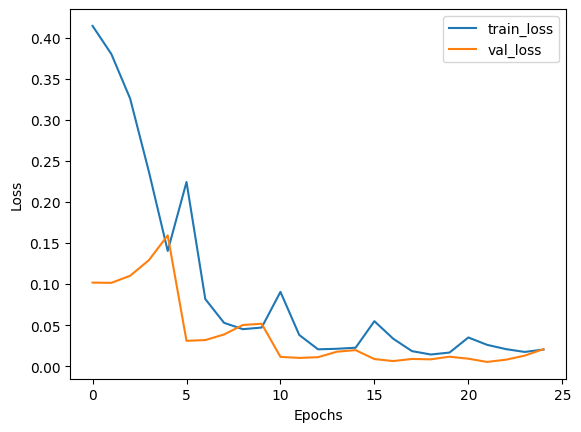

In [ ]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Cody - AIMI 2024/Trains/train_val_loss.png')
plt.show()

# Evaluating on Test Dataset


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('tresnet_l', pretrained=False, num_classes=num_classes)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

checkpoint = torch.load(r'/content/drive/MyDrive/Cody - AIMI 2024/Trains/Run_2/best.ckpt')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])


NameError: name 'Resnext50' is not defined

In [ ]:
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def getImage(image_path):
  image = Image.open(image_path).convert("RGB")
  image = test_transforms(image)
  return image

In [ ]:
threshold = 0.5

def predict(model, image_tensor):
  model.eval()
  with torch.no_grad():
      input = image_tensor.unsqueeze(0)  #image lacks batch layer, so insert a batch dimension of size 1
      input = input.to(device)

      outputs = model(input).cpu()
      preds = np.array(outputs)

      rounded_preds, thresholded_preds = np.empty_like(preds), np.empty_like(preds)
      rounded_preds[:] = preds
      thresholded_preds[:] = preds

      for(i, pred) in enumerate(preds):
              thresholded_preds[i] = (pred > threshold).astype(int)
              if(np.all(thresholded_preds[i] == 0)):
                thresholded_preds[i] = [0, 0, 0, 1]
              rounded_preds[i] = [round(num, 7) for num in pred]

      return thresholded_preds[0], rounded_preds[0]


In [ ]:
test_dataframe = pd.read_csv("/content/drive/MyDrive/Cody - AIMI 2024/2024 AIMI Summer Internship - Intern Materials/Datasets/test_annotations.csv")
os.chdir(r'/content/student_data_split')

In [ ]:
#np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

processed_patients = []
#number_pneumonia = 0 #temporary just to double check

for index, row in tqdm(test_dataframe.iterrows(), total=test_dataframe.shape[0]):
  images = os.listdir(row['study_id'])
  for image in images:
    thresholded_preds, rounded_preds = predict(model, getImage(row['study_id'] + '/' + image))

    patient = {
        'study_id' : row['study_id'],
        'Pneumothorax' : thresholded_preds[1],
        'Pneumonia' : thresholded_preds[0],
        'Pleural Effusion' : thresholded_preds[2],
        'No Finding' : thresholded_preds[3],
        'Pneumothorax Probs' : rounded_preds[1],
        'Pneumonia Probs' : rounded_preds[0],
        'Pleural Effusion Probs' : rounded_preds[2],
        'No Finding Probs' : rounded_preds[3],
    }

    #temporary, check # of pneumonia to make sure not exporting wrong
    #if(thresholded_preds[0] == 1):
    #  number_pneumonia += 1

    processed_patients.append(patient)

    break # too lazy to deal/combine output from multiple images for now, will handle later

#print(f"\n {number_pneumonia} pneumonia detected")

100%|██████████| 2983/2983 [02:08<00:00, 23.24it/s]


In [ ]:
test_processed_dataframe = pd.DataFrame(processed_patients)
test_processed_dataframe.to_csv(r'/content/drive/MyDrive/Cody - AIMI 2024/test_results.csv', index=False, float_format='%.10f')

# Submitting Your Results
Once you have successfully trained your model, generate predictions on the test set and save your results as a `.csv` file. This file can then be uploaded to the leaderboard: https://vilmedic.app/misc/aimi24/leaderboard.

An example `test_results.csv` has been provided for reference only in the `2024 AIMI Summer Internship - Intern Materials/Datasets/Labels` folder. *Do not submit this, the results will be really poor. *

Your final `.csv` file **must** have the following format:
- There must be a column titled `study_id` with the paths to the study_id for the test set image, e.g. `student_test/patient35172/study3`.
- The provided columns from `test_annotations.csv` must be present: "Pneumothorax", "Pneumonia", "Pleural Effusion", "No Finding:
  - Each of these columns must contain a binary value `0` or `1` representing the **observed/ground-truth** absence or presence of the disease status.
- Added columns "Pneumothorax Probs", "Pneumonia Probs", "Pleural Effusion Probs", "No Finding Probs" containing the singular probability values belonging to each class.
  - Each of these columns must contain a continuous value representing the **predicted** probability of the absence or presence of the disease status for that class.
  - *Hint:* Depending on which loss function you used, you might already be outputing probabilities. You can then derive predictions by thresholding your probabilities to a binarized output. If your model outputs logits directly, then apply the sigmoid activation function `torch.sigmoid(logits)` to get probabilities and then threshold to get binary predictions.
- Double check that the length of the dataset passed into your dataloader matches the length of your final dataframe.

In [ ]:
model = # Model Architecture
ckpt = torch.load("/content/best.pkl")
model.load_state_dict(ckpt["state_dict"])

test_dataset = ChestXRayDataset("""Fill in args here""")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, drop_last=False)

In [ ]:
# Write method to load in data from test_loader, compute model predictions, and append results to test_results dict
test_results = {"image_path": [], "pred": []}

In [ ]:
test_results = pd.DataFrame(test_results)
test_results.to_csv(f"/content/test_results.csv")